# 指数追踪 Index Tracking
## —— QTA内培专用

### 概念
- 指数追踪是指通过利用一个的股票组合复制某一现实指数或者虚拟指数的市场表现，来获取与指数相近的收益，试图最小化跟踪误差（tracking error）。

### 特点
- 指数追踪不同于指数复制（Index replication）。前者使用不同于指数的股票池追踪指数表现，而后者使用与指数完全相同的股票复制指数表现。
- 指数追踪通常使用少于指数成分股的股票。一个原因是避免持有过小的和流动性差的头寸，另一个原因是减少交易成本。
- 指数追踪的研究方法与指数增强（Smart Beta）极为相似，仅是目标函数和限制条件有少许不同。
- 指数追踪一般不涉及预测


In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# 读取沪深300成分股
hs300cons = pd.read_csv(r"weight.csv",encoding="gbk")
hs300cons.head(3)

,代码,简称,收盘价,权重,涨跌,涨跌幅,成交量(万),成交额(万),总股本(亿),自由流通股本(亿),...,市盈率-TTM,证监会行业,Wind一级行业,Wind二级行业,Wind三级行业,Wind四级行业,申银万国一级行业,申银万国二级行业,申银万国三级行业,沪港通
0,601318.SH,中国平安,86.12,6.6760%,0.66,0.77%,"7,782.52","671,253.16",182.80,98.70,...,9.99,金融业,金融,保险Ⅱ,保险Ⅲ,多元化保险,非银金融,保险Ⅱ,保险Ⅲ,沪港通
1,600519.SH,贵州茅台,"1,130.00",4.0633%,-53.00,-4.48%,"1,480.99","1,669,683.71",12.56,4.50,...,34.69,制造业,日常消费,食品、饮料与烟草,饮料,白酒与葡萄酒,食品饮料,饮料制造,白酒,沪港通
2,600036.SH,招商银行,38.88,2.8698%,1.30,3.46%,"8,262.45","319,118.07",252.20,124.15,...,10.84,金融业,金融,银行,商业银行,多元化银行,银行,银行Ⅱ,银行Ⅲ,沪港通


In [3]:
# 读取股票行情
stockprice = pd.read_csv(r"stockprice.csv")
stockprice.head(3)

,CODE,EXCHANGE,DATE,PRECLOSE,OPEN,HIGH,LOW,CLOSE,VOLUME,AMOUNT,FLOAT_CAP,MARKET_CAP,PCT_CHANGE,TURNOVER,ID
0,1,SZ,2020-01-02,16.45,16.65,16.95,16.55,16.87,153023187.0,2.571196e+09,3.273750e+11,3.273778e+11,2.55,0.0079,000001.SZ
1,2,SZ,2020-01-02,32.18,32.80,33.60,32.51,32.56,101213040.0,3.342374e+09,3.163259e+11,3.679978e+11,1.18,0.0104,000002.SZ
2,63,SZ,2020-01-02,35.39,35.66,35.80,35.13,35.45,101425488.0,3.592989e+09,1.229751e+11,1.498659e+11,0.17,0.0292,000063.SZ


In [4]:
# 读取沪深300行情
hs300 = pd.read_csv(r"HS300.csv")
hs300.head(3)

,DATE,CLOSE,PCT_CHG
0,2020-01-02,4152.2408,1.3587
1,2020-01-03,4144.9649,-0.1752
2,2020-01-06,4129.2954,-0.3780


### 问题一：已知股票池，确定权重
给定待追踪的指数和它的所有N只成分股，我们要使用已知的n只股票（n<N）追踪指数表现，使得期望跟踪误差尽可能小。

1. 基准指数为 $M$<br>收益率为 $\tilde{r}_m$<br>方差为 $\sigma_m^2=var(\tilde{r}_m)$
2. $n$只股票的收益率为 $\tilde{r}_1,\tilde{r}_2,...\tilde{r}_n$<br>
预期收益率 $\mu_j=E(\tilde{r}_j)$， $\mu = (\mu_1,\mu_2,...\mu_n)^T$，<br>方差 $\sigma_j^2 = var(\tilde{r}_j)$，<br>协方差 $\sigma_{ij}=cov(\tilde{r}_i,\tilde{r}_j)$，协方差矩阵为 $\Sigma$
3. $n$只股票的权重为$x_1,x_2,...x_n$，$\sum_{j=1}^n{x_j}=1$，$x = (x_1,x_2,...x_n)$<br>组合的预期收益率为 $E(\tilde{r}_p)=\sum_{i=j}^n{x_j\tilde{r}_j}$
4. 指数的预期收益率 $\mu_m=E(\tilde{r}_m)$<br>个股与指数协方差为 $\sigma_{jM}=cov(\tilde{r}_j,\tilde{r}_m)$<br>个股Beta系数为 $\beta_j=\frac{\sigma_{jM}}{\sigma_m^2}$，$\beta = (\beta_1,\beta_2,...\beta_n)$

In [5]:
# 指数收益期望
μm = hs300.PCT_CHG.mean()
# 指数收益标准差
σm = hs300.PCT_CHG.std()
# 收益矩阵
stockret = stockprice.pivot("DATE","ID","PCT_CHANGE").fillna(0)
# 选出50只股票
stocklist = stockprice.ID.unique()
stocklist_q1 = stocklist[np.arange(0,300,6)]
stockret_q1 = stockret[stocklist_q1]
# 个股收益期望
μ = stockret_q1.mean(axis=0).values
# 个股收益标准差
σ = stockret_q1.std(axis=0).values
# 协方差矩阵
Σ = stockret_q1.cov().values
# Beta系数
β = (stockret_q1.corrwith(hs300.set_index("DATE").PCT_CHG)*σ/σm).values

在$E(\tilde{r}_p)=E(\tilde{r}_m)$的限制下，跟踪误差为：
\begin{align*}
Var(\tilde{r}_p-\tilde{r}_m)&=\sigma_p^2+\sigma_m^2-2Cov(\tilde{r}_p,\tilde{r}_m) \\
&= \sigma_p^2+\sigma_m^2-2\sum_{j=1}^nx_j\sigma_{jM} \\
&= \sigma_p^2+\sigma_m^2-2\sigma_m^2\sum_{j=1}^nx_j\beta_j \\
&= x^T\Sigma x+\sigma_m^2-2\sigma_m^2\beta^Tx
\end{align*}

由于$\sigma_m$是固定的，我们的目标函数可写为：
$$\begin{align*}
\min_x \ & x^T\Sigma x-2\sigma_m^2\beta^Tx \\
\mbox{s.t. }  & \mu ^ T x = \mu_m\\
& \textbf{1} ^ T x = 1
\end{align*}$$
该目标函数可用 [cvxpy](https://www.cvxpy.org/examples/basic/quadratic_program.html) 求解。

In [18]:
# 使用cvxpy求解
n = 50
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(cp.quad_form(x, Σ) - 2*σm**2*β.T @ x),
                 [μ.T @ x == μm,
                  np.ones(n) @ x == 1,
                  x >= 0])
prob.solve()
x_sol = x.value
x_sol

array([ 6.17540267e-02,  3.77789867e-04,  1.69254869e-22,  2.69884792e-02,
       -9.53482450e-23,  3.72229875e-02, -1.33319599e-22,  2.87415402e-02,
        1.57455346e-02,  1.57597939e-03,  1.33019936e-02,  5.44379625e-03,
        6.56548031e-02, -1.58204492e-22,  6.91152584e-02,  8.12867080e-03,
       -6.81471090e-23, -2.67938006e-23, -8.73318686e-23,  6.47847914e-02,
       -7.65517976e-23,  5.19206029e-02,  1.61017148e-22,  3.41362310e-02,
        2.15770996e-02,  3.56576416e-02,  1.03241802e-22, -2.23471478e-23,
       -1.92038143e-22,  2.06100442e-02,  5.13031077e-02,  1.40584867e-02,
        4.46372590e-03,  4.00772747e-03,  3.19563615e-02,  2.80653081e-03,
        3.08679954e-02,  1.24212041e-02,  9.87660904e-23,  6.96185865e-02,
        4.76213780e-02,  7.35967307e-02,  7.86363580e-23,  1.17329961e-02,
        5.97508641e-02,  9.84200989e-24,  9.77259828e-04,  1.88155679e-02,
        6.35255690e-23,  3.26420697e-03])

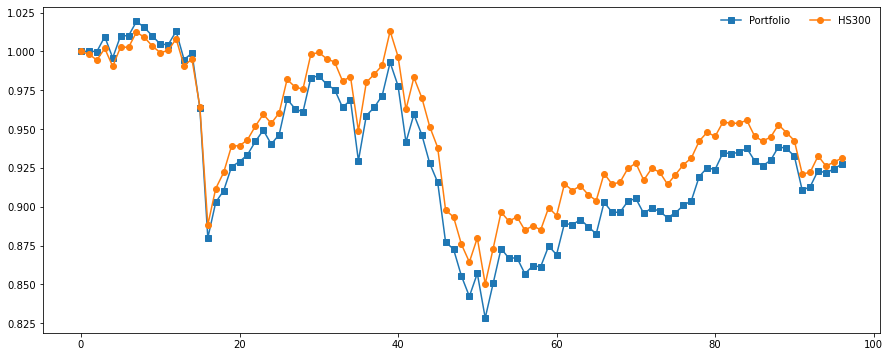

In [19]:
# 组合和指数收益率比较
pf_ret = stockret_q1.apply(lambda x:x.values @ x_sol,axis=1)
pf_ret[0] = 0
pf = (pf_ret/100+1).cumprod()

# 作图
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
plt.plot(np.arange(len(pf)), 
         pf.values,
         '-s',
         label='Portfolio')
plt.plot(np.arange(len(pf)), 
         hs300.CLOSE/hs300.loc[0,'CLOSE'],
         '-o',
         label='HS300')
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(handles, labels,ncol=2, frameon=False)
plt.show()

### 问题二：从N只成分股中选择n只股票作为股票池（简单权重）
给定待追踪的指数和它的所有N只成分股，我们要从中选出n只股票（n<N）追踪指数表现，使得这n只股票能最好的代表N只成分股。

核心思想：我们应该使用相似性高的股票来代表原有股票，从而缩减股票的数量。
1. 记 $\rho_{ij}$ 为第$i$只股票和第$j$只股票的相似程度。一般取 $\rho_{ij}$ 为相关系数，$\rho_{jj}=1$
2. 我们用 $y_i \in \{0,1\}$ 来表示第$i$只股票是否被选入，则$$\sum_{i=1}^N y_i=n$$
3. 我们用 $x_{ij} \in \{0,1\}$ 来表示第$i$只股票是否被第$j$只股票代表，则$$\sum_{j=1}^N x_{ij}=1$$$$x_{ij}\leq y_j \; \forall i,j$$

In [6]:
# 相关系数矩阵
ρ = stockret.corr().values
np.shape(ρ)

(300, 300)

我们的目标函数为：
$$\begin{align*}
\max_{y_j,x_{ij}} \ & \sum_{i=1}^N \sum_{j=1}^N \rho_{ij}x_{ij} \\
\mbox{s.t. }  & \sum_{i=1}^N y_i=n\\
& \sum_{j=1}^N x_{ij}=1\\
& x_{ij}\leq y_j \; \forall i,j\\
& x_{ij},y_j \in \{0,1\} \; \forall i,j
\end{align*}$$<br>
这是一个MILP（Mixed Integer linear Programming）问题，可以用 [cvxpy](https://www.cvxpy.org/examples/basic/mixed_integer_quadratic_program.html) 求解。得出结果后，目标权重可简单的用
$X_j=\sum_{i=1}^N V_i x_{ij}$ 决定，其中$V_i$是第$i$只股票的市值在指数市值中的权重。

In [7]:
n = 300
opt_n = 50
ρ = ρ.flatten()
x = cp.Variable(n**2, integer=True)
y = cp.Variable(n, integer=True)
constraint1 = [
     np.ones(n) @ x[i*n:(i+1)*n] == 1 for i in range(n)
]
constraint2 = [
     x[i] <= y[(i % n)] for i in range(n**2)
]
prob = cp.Problem(cp.Minimize(ρ @ x),
                  [np.ones(n) @ y == opt_n] + constraint1 + constraint2 + [x >= 0] + [y >=0 ] + [y <= 1])
prob.solve()

-14.536057744050394

In [2]:
# 替代矩阵
x_sol = x.value
#x_sol

In [21]:
# 目标股票池
y_sol = y.value
stocklist[y_sol==1]
list(hs300cons[hs300cons['代码'].isin(stocklist[y_sol==1])]['简称'])

['中国平安',
 '五粮液',
 '中信证券',
 '万科A',
 '民生银行',
 '交通银行',
 '浦发银行',
 '海康威视',
 '京东方A',
 '上海机场',
 '隆基股份',
 '中国石化',
 'TCL科技',
 '南京银行',
 '宝钢股份',
 '爱尔眼科',
 '华夏银行',
 '申万宏源',
 '三安光电',
 '广发证券',
 '新希望',
 '汇川技术',
 '中国核电',
 '包钢股份',
 '双汇发展',
 '新和成',
 '长江证券',
 '徐工机械',
 '紫光股份',
 '光大证券',
 '雅戈尔',
 '完美世界',
 '华能国际',
 '北新建材',
 '华东医药',
 '国元证券',
 '白云机场',
 '恒逸石化',
 '上海莱士',
 '西南证券',
 '阳光城',
 '中国动力',
 '苏泊尔',
 '华电国际',
 '美锦能源',
 '河钢股份',
 '信立泰',
 '鞍钢股份',
 '九州通',
 '合盛硅业']

- 简单替代组合：目标权重简单的用
$X_j=\sum_{i=1}^N V_i x_{ij}$ 决定，其中$V_i$是第$i$只股票的市值在指数市值中的权重。

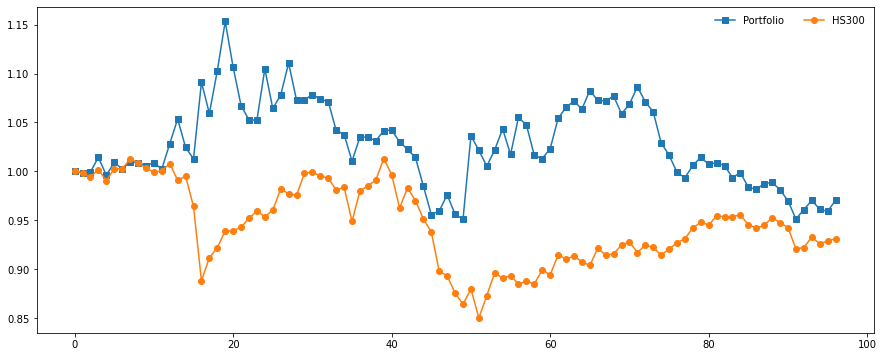

In [10]:
x_replace = x_sol.reshape(n,n)
weight = hs300cons.sort_values("代码",ascending=True).reset_index(drop=True)['权重']
weight = weight.str.replace("%","").astype(float)
pf_weight = np.transpose(x_replace) @ weight

pf_ret = stockret.apply(lambda x:x.values @ pf_weight/100,axis=1)
pf_ret[0] = 0
pf = (pf_ret/100+1).cumprod()

# 作图
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
plt.plot(np.arange(len(pf)), 
         pf.values,
         '-s',
         label='Portfolio')
plt.plot(np.arange(len(pf)), 
         hs300.CLOSE/hs300.loc[0,'CLOSE'],
         '-o',
         label='HS300')
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(handles, labels,ncol=2, frameon=False)
plt.show()

- 用问题一的思路确定权重

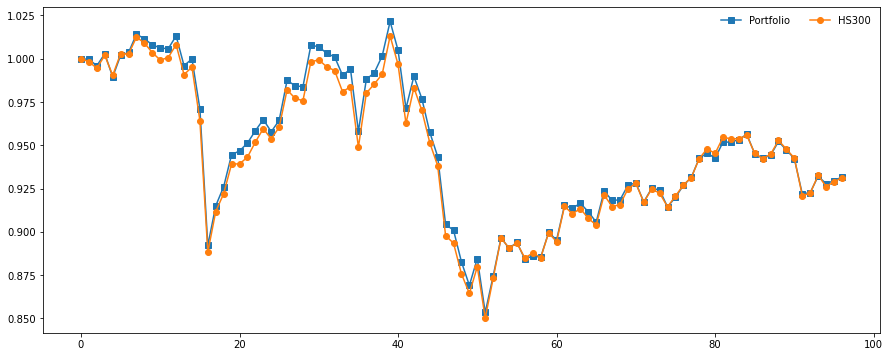

In [24]:
stocklist_q2 = stocklist[y_sol == 1]
stockret_q2 = stockret[stocklist_q2]


def index_tracking_graph_q1(stockret,stocklist):
    # 样本数据计算
    stockret_q1 = stockret[stocklist]
    # 个股收益期望
    μ = stockret_q1.mean(axis=0).values
    # 个股收益标准差
    σ = stockret_q1.std(axis=0).values
    # 协方差矩阵
    Σ = stockret_q1.cov().values
    # Beta系数
    β = (stockret_q1.corrwith(hs300.set_index("DATE").PCT_CHG)*σ/σm).values
    
    # cvxpy求解
    n = len(stocklist_q1)
    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize(cp.quad_form(x, Σ) - 2*σm**2*β.T @ x),
                     [μ.T @ x == μm,
                      np.ones(n) @ x == 1,
                      x >= 0])
    prob.solve()
    x_sol = x.value
    
    # 计算组合净值
    pf_ret = stockret_q1.apply(lambda x:x.values @ x_sol,axis=1)
    pf_ret[0] = 0
    pf = (pf_ret/100+1).cumprod()

    # 作图
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    plt.plot(np.arange(len(pf)), 
             pf.values,
             '-s',
             label='Portfolio')
    plt.plot(np.arange(len(pf)), 
             hs300.CLOSE/hs300.loc[0,'CLOSE'],
             '-o',
             label='HS300')
    handles, labels = ax.get_legend_handles_labels()
    legend = plt.legend(handles, labels,ncol=2, frameon=False)
    plt.show()
    
index_tracking_graph_q1(stockret,stocklist_q2)

### 问题三：一般问题
给定待追踪的指数和它的所有N只成分股，我们要从中选出n只股票（n<N）追踪指数表现，使得实际跟踪误差尽可能小。

1. 记 $\tilde{r}_t=(\tilde{r}_t^1,\tilde{r}_t^2,...\tilde{r}_t^N)^T$ 为$t$期股票的收益，$\tilde{r}_t^m$为$t$期指数的收益
2. 记 $w=(w_1,w_2,...w_N)^T$ 为目标股票权重，其中$w_i=0$ 意味着第$i$只股票未被选入股票池<br>则$t$期组合的收益为$\tilde{r}_t^p(w)=\tilde{r}_t^T w$
3. 假设 $0<\epsilon_i<\xi_i<1$ 为第i只股票的（持有）仓位限制，则
$$\epsilon_i y_i \leq w_i \leq \xi_i y_i $$<br>$$\text{其中 } y_i=\left\{\begin{aligned}1, & \text{ if } w_i>0 \\0, & \text{ else }\end{aligned}\right.$$<br>$$\text{且 }L \leq \sum_{i=1}^N y_i \leq K$$
4. 令 $\bar{w}_i$ 表示指数成分的权重，换手率限制为:
$$\sum_{i=1}^N |w_i-\bar{w}_i| \leq TO$$
引入 $\gamma_i =|w_i-\bar{w}_i|$ ,换手率限制可以表示为：
$$\sum_{i=1}^N \gamma_i \leq TO$$
$$- \gamma_i \leq w_i-\bar{w}_i \leq \gamma_i$$

在以上条件下，我们的目标函数为：
$$\begin{align*}
\min_{w_i,y_i,\gamma_i} \ & f(w) = \sqrt{\frac{1}{T} \sum_{t=1}^T (\tilde{r}_t^p(w)-\tilde{r}_t^m)^2} \\
\mbox{s.t. }  & \epsilon_i y_i \leq w_i \leq \xi_i y_i \\
& L \leq \sum_{i=1}^N y_i \leq K\\
& y_i \in \{0,1\} \; \forall i \\
& \sum_{i=1}^N \gamma_i \leq TO \\
& - \gamma_i \leq w_i-\bar{w}_i \leq \gamma_i
\end{align*}$$<br>
这是一个MIQP（Mixed Integer Quadratic Programming）问题，cvxpy无法求解。可以使用Matlab的TOMLAB或IBM cplex求解。

#### Homework：替代方案
我们可以把目标函数 $\min_{w_i,y_i,\gamma_i}  f(w) = \sqrt{\frac{1}{T} \sum_{t=1}^T (\tilde{r}_t^p(w)-\tilde{r}_t^m)^2}$ 替换为 $\min_{w_i,y_i,\gamma_i}  f(w) = \frac{1}{T} \sum_{t=1}^T |\tilde{r}_t^p(w)-\tilde{r}_t^m|$ ，这样就可以使用cvxpy求解（但是非常非常慢！）

In [ ]:
n = 300
ϵ = np.ones(n)*0.1
ξ = np.ones(n)*10

rm = hs300.PCT_CHG.values
r = stockret.values
wm = hs300cons.sort_values("代码",ascending=True).reset_index(drop=True)['权重'].str.replace("%","").astype(float).values
L = 30
K = 50
TO = 50
nt = len(rm)

w = cp.Variable(n)
y = cp.Variable(n, integer=True)
γ = cp.Variable(n)
z = cp.Variable(nt)

objective = cp.Minimize(np.ones(nt) @ z)
constraint1 = [
     ϵ[i]*y[i] <= w[i] for i in range(n)
]
constraint2 = [
     ξ[i]*y[i] >= w[i] for i in range(n)
]
constraint3 = [
     -γ[i] <= w[i] - wm[i] for i in range(n)
]
constraint4 = [
     γ[i] >= w[i] - wm[i] for i in range(n)
]
constraint5 = [
     (r @ w - rm)[i] <= z[i] for i in range(nt)
]
constraint6 = [
     (rm - r @ w)[i] <= z[i] for i in range(nt)
]
prob = cp.Problem(objective,
                  constraint1 + constraint2 + \
                  [np.ones(n) @ y >= L] + [np.ones(n) @ y <= K] + \
                  [y <= 1] + [y >= 0] + [γ >= 0] + \
                  [np.ones(n) @ γ <= TO] + constraint3 + constraint4 + \
                  [z >= 0] + constraint5 + constraint6)
prob.solve()

In [ ]:
w_sol = w.value

# 计算组合净值
pf_ret = stockret.apply(lambda x:x.values @ w_sol,axis=1)
pf_ret[0] = 0
pf = (pf_ret/100+1).cumprod()

# 作图
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
plt.plot(np.arange(len(pf)), 
         pf.values,
         '-s',
         label='Portfolio')
plt.plot(np.arange(len(pf)), 
         hs300.CLOSE/hs300.loc[0,'CLOSE'],
         '-o',
         label='HS300')
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(handles, labels,ncol=2, frameon=False)
plt.show()